# Import necessary libraries

In [1]:
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests 
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings 
warnings.filterwarnings("ignore")

# Open and prepare the files

To find the differential expressed genes we need the scaled data, and the file cluster_labs, where its indicated which cluster each sample belongs to.

In [4]:
file_path_d = '/Volumes/TOSHIBA/4t/Advanced Bioinformatics/Project/Python/scaled_data.csv'
file_path_c = '/Volumes/TOSHIBA/4t/Advanced Bioinformatics/Project/Python/cluster_labs.csv'

df = pd.read_csv(file_path_d, index_col = 0)
clust = pd.read_csv(file_path_c, index_col = 0)

Now, we are going to create a dictionary where the keys are the different clusters (1, 2, 3, 4) and values are names of samples.

In [5]:
clust_dic = {cluster: clust.index[clust['x'] == cluster].tolist() for cluster in range(1, 5)}

# Find DEGs of each group of samples

First we are going to create the function that we are going to apply on out data do find
DEGs:
For each cluster (each key in the dictionary clust_dic), we pick all the samples and we also define other clusters samples; so we can perform t-test for each gene of the data between the current cluster and the rest and calculate its FC.
Then, for the obtained results, we will adjust the p - values using FDR correction (alpha = 0.05). Finally, we will categorize genes based on adjusted p-values and fold changes in three groups: normal, up, and down.

In [7]:
def find_cluster_specific_degs(clustered_samples, dataframe, t_fc = 1.0):
    path = '/Volumes/TOSHIBA/4t/Advanced Bioinformatics/Project/Python/'
    cluster_results = defaultdict(dict)
    cluster_results = defaultdict(lambda: {
        "genes": [],
        "p_values": [],
        "fold_changes": [],
        "adj_p_values": [],
        "DEGs": []
    })

    for cluster in clustered_samples:
        cluster_samples = clustered_samples[cluster]
        other_samples = [sample for other_cluster in clustered_samples if other_cluster != cluster
                         for sample in clustered_samples[other_cluster]]

        for gene in dataframe.index:
            cluster_expression = dataframe.loc[gene, cluster_samples]
            other_expression = dataframe.loc[gene, other_samples]

            fold_change = np.mean(cluster_expression) - np.mean(other_expression)
            t_stat, p_value = ttest_ind(cluster_expression, other_expression)

            cluster_results[cluster]["genes"].append(gene)
            cluster_results[cluster]["p_values"].append(p_value)
            cluster_results[cluster]["fold_changes"].append(fold_change)

    for cluster, data in cluster_results.items():
        _, adjusted_p_values, _, _ = multipletests(data["p_values"], alpha = 0.05, method='fdr_bh')
        data["adj_p_values"] = adjusted_p_values
        data["DEGs"] = []

        for p_val, fc in zip(data["adj_p_values"], data["fold_changes"]):
            if p_val <= 0.05 and abs(fc) >= t_fc:
                data["DEGs"].append("UP" if fc > 0 else "DOWN")
            else:
                data["DEGs"].append("NORMAL")

        result_df = pd.DataFrame({
            "Gene": data["genes"],
            "P-Value": data["p_values"],
            "Adjusted P-Value": data["adj_p_values"],
            "Fold Change": data["fold_changes"],
            "DEGs": data["DEGs"]
        })
        file_path = os.path.join(path, f'cluster_{cluster}_degs.csv')
        result_df.to_csv(file_path, index=False)
    return cluster_results

Now, we can apply the created function to find each cluster-specific DEGs; and see how many upregulated and downregulated genes we have in each group. If we then visualize top 5 DEGs of each cluster, we can see that all obtained p - values are so close to 0 (but probably not 0). That's because our clusters of samples are well defined and really different from each other.

In [8]:
cluster_specific_degs = find_cluster_specific_degs(clust_dic, df)

In [9]:
for cluster, data in cluster_specific_degs.items():

    sorted_indices = sorted(range(len(data["adj_p_values"])), key=lambda k: data["adj_p_values"][k])
    top_5_indices = sorted_indices[:5]
    top_5_genes = [data["genes"][idx] for idx in top_5_indices]
    top_5_pvalues = [data["adj_p_values"][idx] for idx in top_5_indices]
    
    print(f"Cluster {cluster} DEGs:")
    print(f"Number of upregulated genes: {sum([1 for deg in data['DEGs'] if deg == 'UP'])}")
    print(f"Number of downregulated genes: {sum([1 for deg in data['DEGs'] if deg == 'DOWN'])}")
    print("\n")

    print(f"Top 5 DEGs for Cluster {cluster}:")
    for gene, p_value in zip(top_5_genes, top_5_pvalues):
        print(f"Gene: {gene}, Adjusted P-Value: {p_value:.4f}")
    print("\n")


Cluster 1 DEGs:
Number of upregulated genes: 38
Number of downregulated genes: 252


Top 5 DEGs for Cluster 1:
Gene: ENSG00000267710.9, Adjusted P-Value: 0.0000
Gene: ENSG00000248487.9, Adjusted P-Value: 0.0000
Gene: ENSG00000167363.14, Adjusted P-Value: 0.0000
Gene: ENSG00000279384.1, Adjusted P-Value: 0.0000
Gene: ENSG00000207370.1, Adjusted P-Value: 0.0000


Cluster 2 DEGs:
Number of upregulated genes: 306
Number of downregulated genes: 15


Top 5 DEGs for Cluster 2:
Gene: ENSG00000124575.7, Adjusted P-Value: 0.0000
Gene: ENSG00000168298.7, Adjusted P-Value: 0.0000
Gene: ENSG00000183562.3, Adjusted P-Value: 0.0000
Gene: ENSG00000183598.4, Adjusted P-Value: 0.0000
Gene: ENSG00000184260.6, Adjusted P-Value: 0.0000


Cluster 3 DEGs:
Number of upregulated genes: 138
Number of downregulated genes: 120


Top 5 DEGs for Cluster 3:
Gene: ENSG00000073282.14, Adjusted P-Value: 0.0000
Gene: ENSG00000081277.13, Adjusted P-Value: 0.0000
Gene: ENSG00000087494.16, Adjusted P-Value: 0.0000
Gene: EN

# Visualizing the results: Volcano plots

To visualize DEGs, we are going to do a volcano plot for each comparison (so 4 plots, of each cluster genes expression compared to all others).

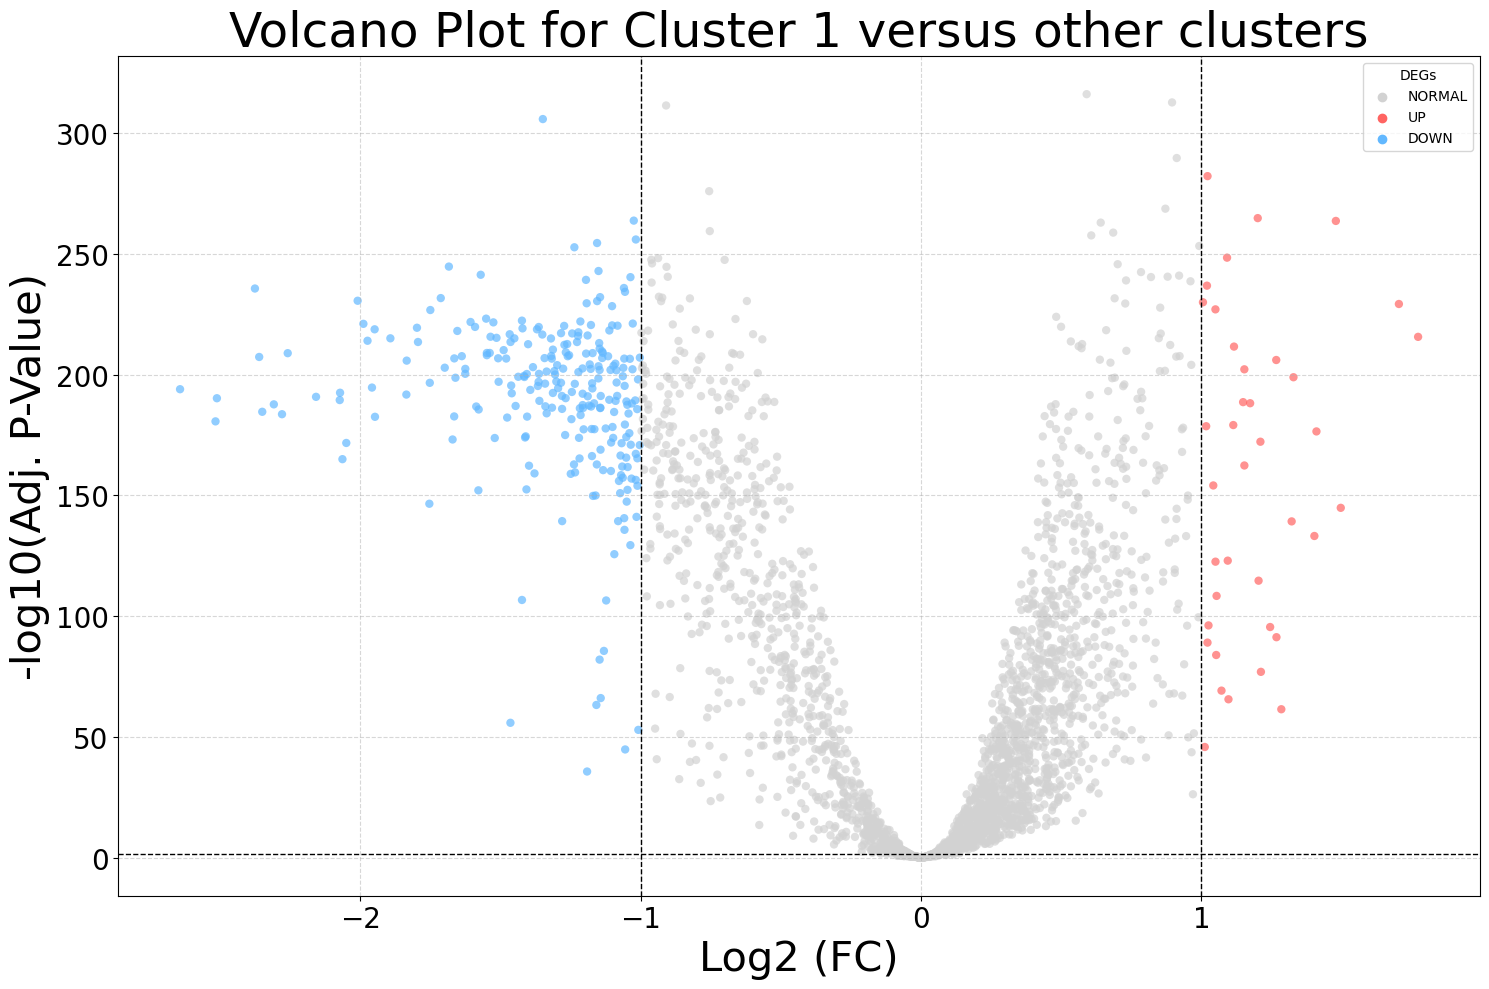

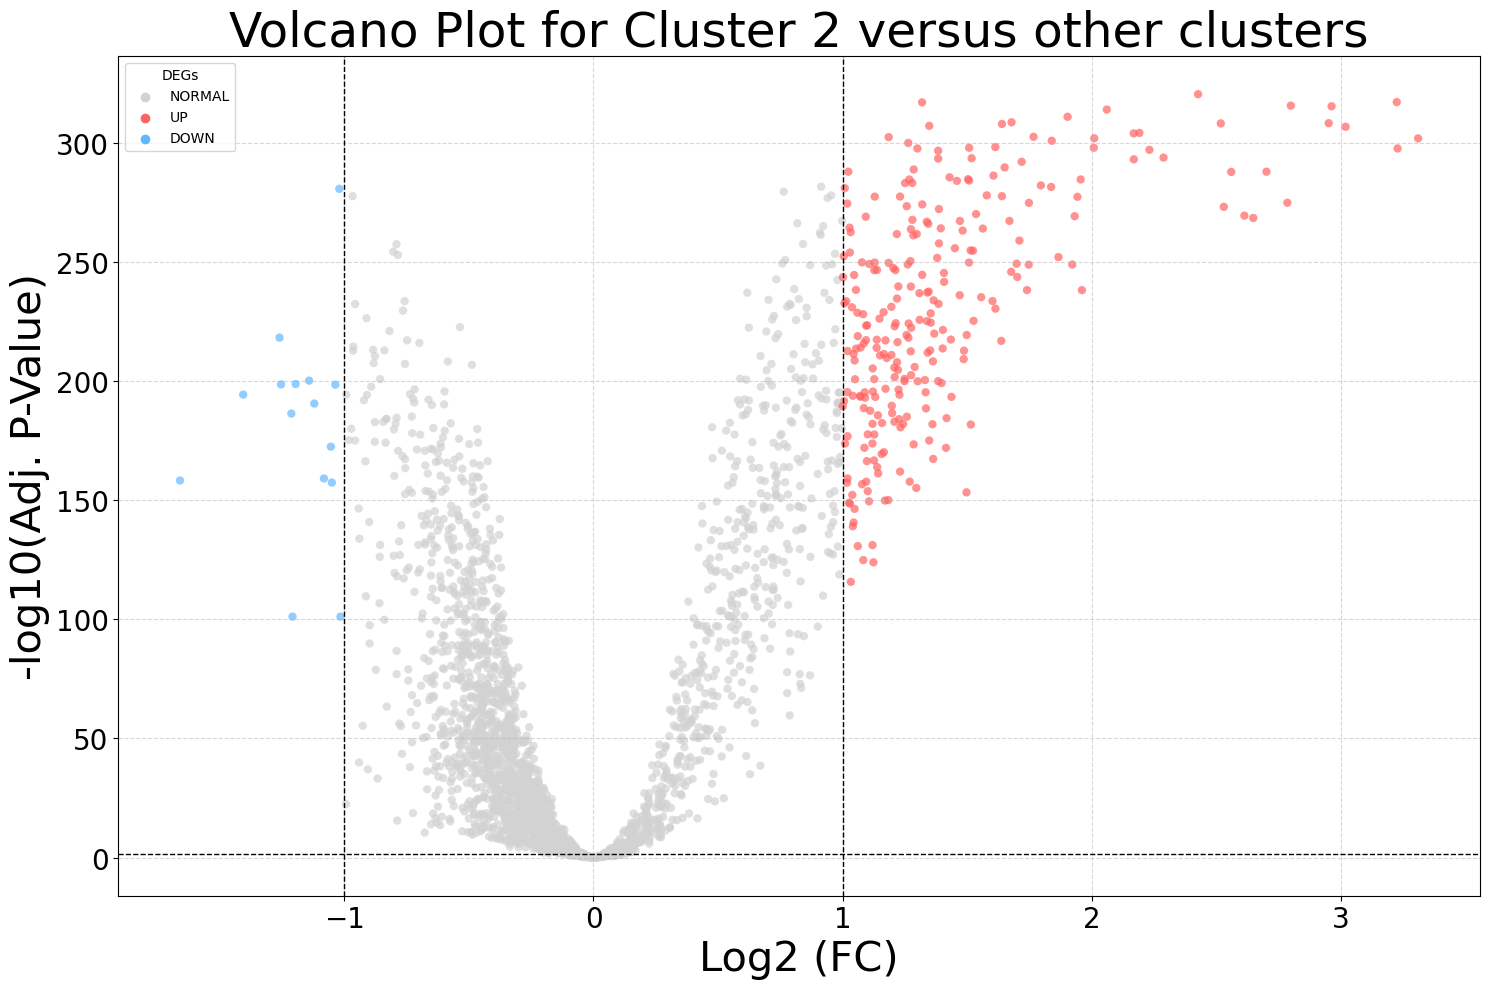

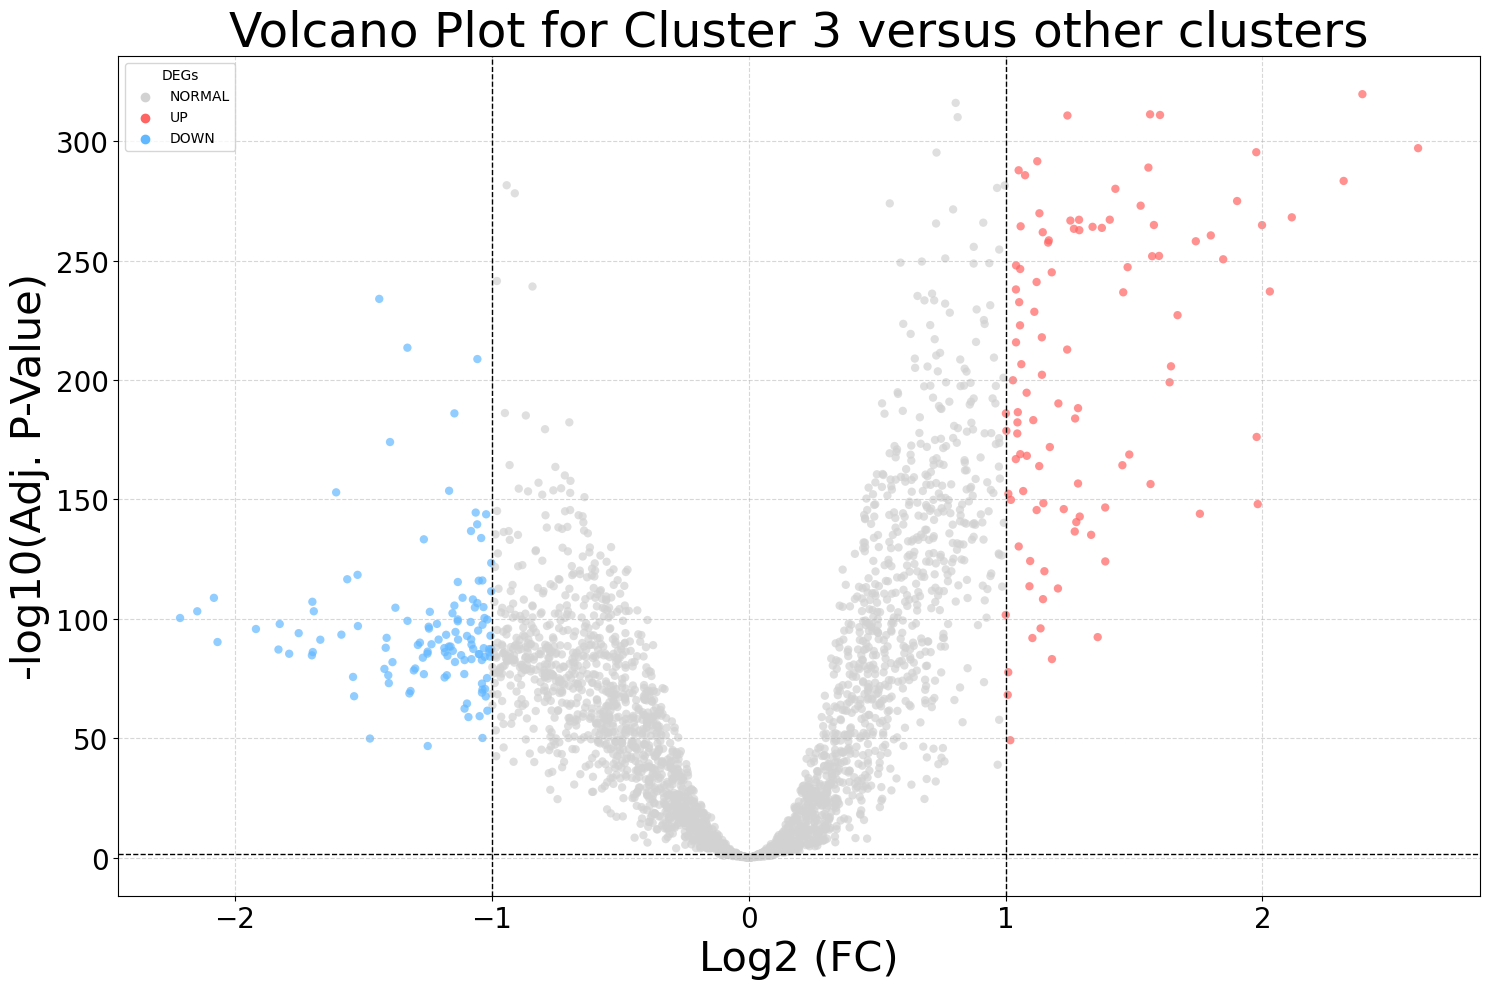

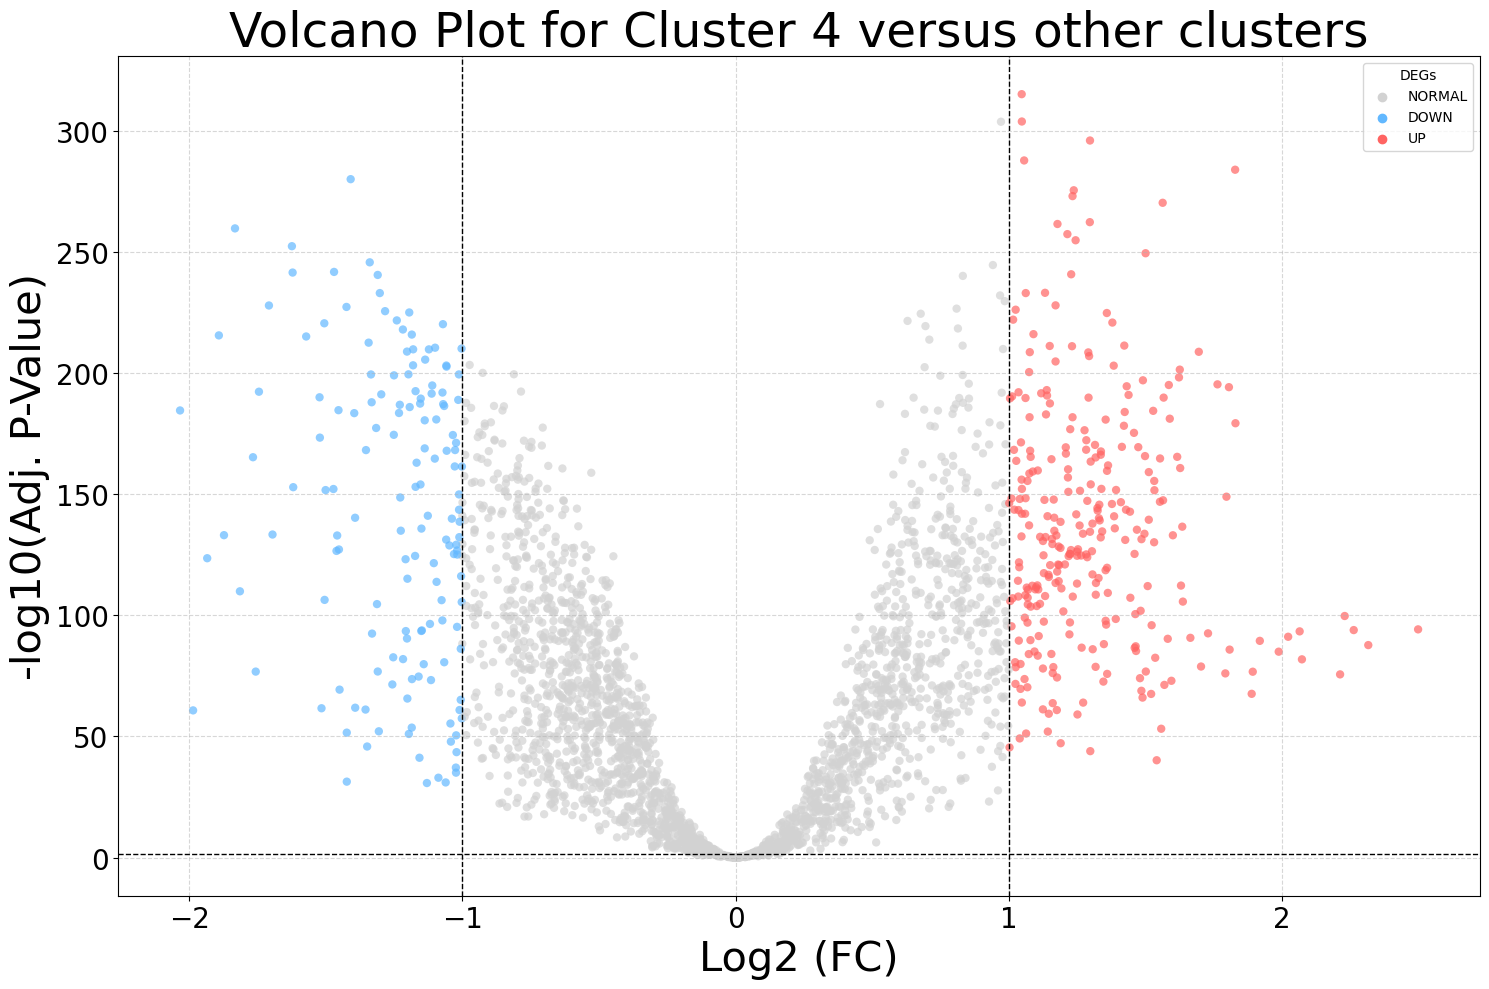

In [10]:
colors = {"NORMAL":"#D2D2D2", "UP":"#FF6462", "DOWN":"#62B8FF"} 

for cluster, data in cluster_specific_degs.items():
    cluster_df = pd.DataFrame({
        "Gene": data["genes"],
        "Adjusted P-Value": data["adj_p_values"],
        "Fold Change": data["fold_changes"],
        "DEGs": data["DEGs"]
    })
    plt.figure(figsize = (15, 10))
    sns.scatterplot(x = cluster_df["Fold Change"], y = -np.log10(cluster_df["Adjusted P-Value"]),
                    hue = cluster_df["DEGs"], palette = colors, edgecolor = "none", alpha = 0.7)
    
    plt.axhline(-np.log10(0.05), color="k", linestyle="--", linewidth=1)
    plt.axvline(1, color="k", linestyle="--", linewidth=1)
    plt.axvline(-1, color="k", linestyle="--", linewidth=1)

    plt.xlabel("Log2 (FC)", fontsize = 30)
    plt.ylabel("-log10(Adj. P-Value)", fontsize = 30)
    plt.title(f"Volcano Plot for Cluster {cluster} versus other clusters", fontsize = 35)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"volcano_plot_cluster_{cluster}.png")